# Exploring GTSAM  Package for Pose Optimization with Factor Graphs

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

# import gtsampy as gtsam
import gtsam
import gtsam.utils.plot as gtsam_plot
import matplotlib.pyplot as plt
import numpy as np

Autosaving every 180 seconds


# Establish Origin 

$ [x, y, z, \phi, \theta, \psi ] $

In [2]:
p = np.array([0,0,0,0,0,0], dtype = np.float64)
start = gtsam.Pose3(p)
print(start)

# newpt = gtsam.Pose3(np.array([1,1,1,0,0,0], dtype = np.float64))

R: [
	0, 6.92386e-310, 0;
	0, 6.37345e-322, 0;
	0, 1.97087e-316, 0
]
t: 0 0 0



# 2D Odometry Example

X1 covariance:
[[ 9.00000000e-02 -1.79856130e-17 -4.45600228e-18]
 [-1.79856130e-17  9.00000000e-02  1.91846539e-17]
 [-4.45600228e-18  1.91846539e-17  1.00000000e-02]]

X2 covariance:
[[0.13039867 0.00397339 0.00199667]
 [0.00397339 0.16960133 0.01990008]
 [0.00199667 0.01990008 0.02      ]]

X3 covariance:
[[0.17396282 0.02755595 0.00796672]
 [0.02755595 0.36563751 0.0594015 ]
 [0.00796672 0.0594015  0.27      ]]



<IPython.core.display.Javascript object>


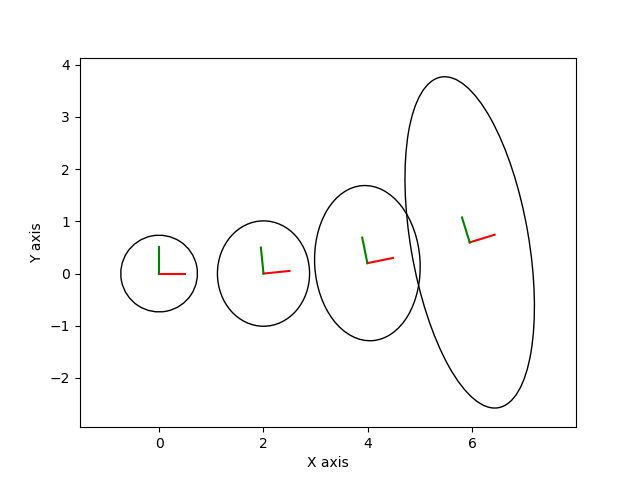

In [48]:
# Create noise models
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1]))  #for 0-1
ODOMETRY_NOISE2 = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.5])) #for 1-2
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.1]))

# Create an empty nonlinear factor graph
graph = gtsam.NonlinearFactorGraph()

# Add a prior on the first pose, setting it to the origin
# A prior factor consists of a mean and a noise model (covariance matrix)
priorMean = gtsam.Pose2(0.0, 0.0, 0.0)  # prior at origin
graph.add(gtsam.PriorFactorPose2(1, priorMean, PRIOR_NOISE))

# Add odometry factors
odometry = gtsam.Pose2(2.0, 0.0, 0.1)
# For simplicity, we will use the same noise model for each odometry factor
# Create odometry (Between) factors between consecutive poses
graph.add(gtsam.BetweenFactorPose2(1, 2, odometry, ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPose2(2, 3, odometry, ODOMETRY_NOISE2))
graph.add(gtsam.BetweenFactorPose2(3, 4, odometry, ODOMETRY_NOISE2)) #test
# print("\nFactor Graph:\n{}".format(graph))

# Create the data structure to hold the initialEstimate estimate to the solution
# For illustrative purposes, these have been deliberately set to incorrect values
initial = gtsam.Values()
initial.insert(1, gtsam.Pose2(0.5, 0.0, 0.2))
initial.insert(2, gtsam.Pose2(2.3, 0.1, -0.2))
initial.insert(3, gtsam.Pose2(4.1, 0.1, 0.1))
initial.insert(4, gtsam.Pose2(4.1, 0.1, 0.1))#test
# print("\nInitial Estimate:\n{}".format(initial))

# optimize using Levenberg-Marquardt optimization
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
result = optimizer.optimize()
# print("\nFinal Result:\n{}".format(result))

# 5. Calculate and print marginal covariances for all variables
marginals = gtsam.Marginals(graph, result)
for i in range(1, 4):
    print("X{} covariance:\n{}\n".format(i,
                                         marginals.marginalCovariance(i)))

for i in range(1, 5):
    gtsam_plot.plot_pose2(0, result.atPose2(i), 0.5,
                          marginals.marginalCovariance(i))
plt.axis('equal')
plt.show()


In [47]:
#test plotting 2D odometry estimates
# a = gtsam.Pose2(0.5, 0.0, 0.2)

print(result.atPose2(2))


(2, 7.03788221e-15, 2.92725806e-15)



# Pose3 SLAM Example

g2o is a file format for representing human-readable graphs for optimization problems
https://github.com/uoip/g2opy

In [28]:
g2oFile = "gtsampy/Data/pose3example.txt"
# g2oFile = gtsam.findExampleDataFile("pose3example.txt")
is3D = True
graph, initial  = gtsam.readG2o(g2oFile, is3D)
# print(initial)

priorModel = gtsam.noiseModel.Diagonal.Variances(
        np.array([1e-6, 1e-6, 1e-6, 1e-4, 1e-4, 1e-4]))

firstKey = initial.keys()[0]
graph.add(gtsam.PriorFactorPose3(0, gtsam.Pose3(), priorModel))

initialization = gtsam.InitializePose3.initialize(graph)
# print(initialization)